In [2]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel

FULL GP REGRESSION - EXPLICIT MATRICES

Training points: 20
Test points: 200

K_XX shape (train-train kernel): torch.Size([20, 20])
K̂_XX^{-1} shape (inverse): torch.Size([20, 20])
K_X*X shape (test-train kernel): torch.Size([200, 20])
K_X*X* shape (test-test kernel): torch.Size([200, 200])

Posterior mean shape: torch.Size([200])
Posterior covariance shape: torch.Size([200, 200])
Posterior variance shape: torch.Size([200])

Covariance eigenvalues: min=-0.000005, max=18.534813
Negative eigenvalues: 91 (numerical noise)


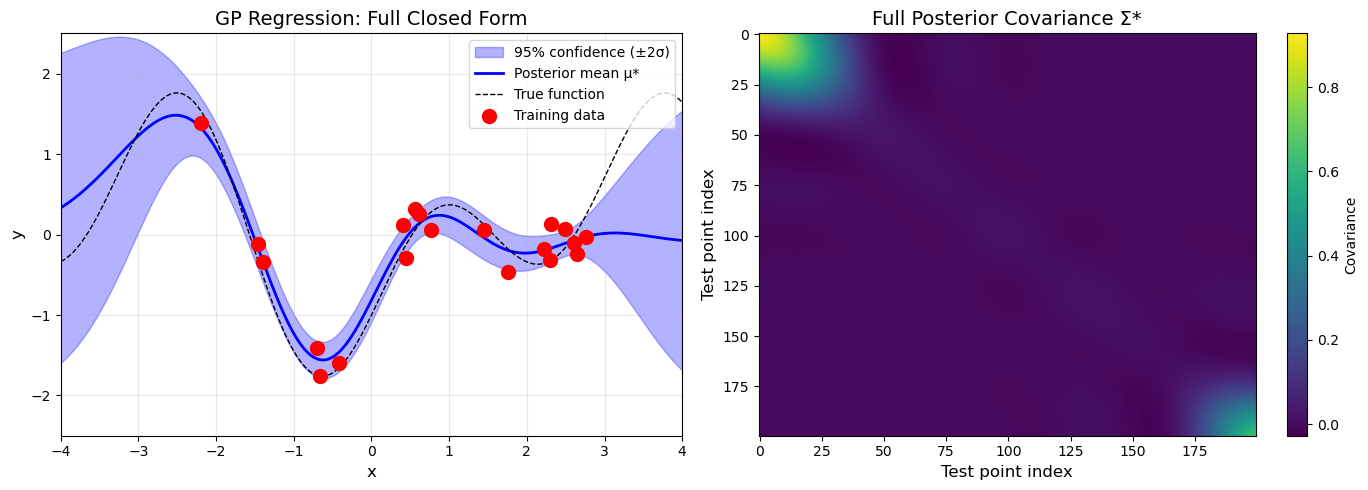


SAMPLING FROM FULL POSTERIOR
Raw eigenvalues range: [-4.95e-06, 1.85e+01]


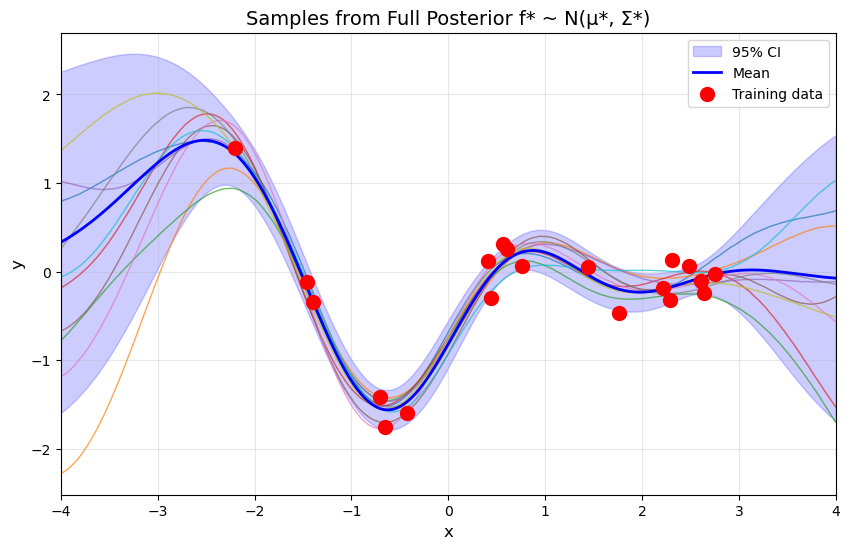


Key observations:
- Samples are CORRELATED (smooth, not jagged)
- They pass through/near training points
- They diverge far from training data (uncertainty increases)


In [1]:
import torch
import matplotlib.pyplot as plt

# =============================================================================
# FULL EXPLICIT GP REGRESSION - NO TRICKS
# =============================================================================

class RBFKernel:
    def __init__(self, lengthscale=1.0, outputscale=1.0):
        self.lengthscale = lengthscale
        self.outputscale = outputscale
    
    def __call__(self, X1, X2):
        dist_sq = torch.cdist(X1, X2, p=2).pow(2)
        return self.outputscale**2 * torch.exp(-dist_sq / (2 * self.lengthscale**2))


class FullGP:
    """
    Full GP regression with explicit matrix inverse.
    
    Posterior formulas:
        μ* = K_X*X @ K̂_XX^{-1} @ y
        Σ* = K_X*X* - K_X*X @ K̂_XX^{-1} @ K_XX*
        
    where K̂_XX = K_XX + σ²I
    """
    
    def __init__(self, lengthscale=1.0, outputscale=1.0, noise=0.1):
        self.kernel = RBFKernel(lengthscale, outputscale)
        self.noise = noise
        
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        
        N = len(X_train)
        
        # K_XX: kernel matrix between training points, shape (N, N)
        K_XX = self.kernel(X_train, X_train)
        
        # K̂_XX = K_XX + σ²I: noisy kernel matrix
        K_XX_noisy = K_XX + self.noise**2 * torch.eye(N)
        
        # Explicit inverse: K̂_XX^{-1}
        self.K_XX_noisy_inv = torch.linalg.inv(K_XX_noisy)
        
    def predict(self, X_test):
        """
        Full closed-form prediction.
        
        μ* = K_X*X @ K̂_XX^{-1} @ y
        Σ* = K_X*X* - K_X*X @ K̂_XX^{-1} @ K_XX*
        """
        # K_X*X: kernel between test and train, shape (M, N)
        K_X_star_X = self.kernel(X_test, self.X_train)
        
        # K_XX*: kernel between train and test, shape (N, M)
        K_X_X_star = self.kernel(self.X_train, X_test)
        
        # K_X*X*: kernel between test and test, shape (M, M)
        K_X_star_X_star = self.kernel(X_test, X_test)
        
        # =================================================================
        # POSTERIOR MEAN
        # μ* = K_X*X @ K̂_XX^{-1} @ y
        # =================================================================
        mean = K_X_star_X @ self.K_XX_noisy_inv @ self.y_train
        
        # =================================================================
        # POSTERIOR COVARIANCE (full matrix!)
        # Σ* = K_X*X* - K_X*X @ K̂_XX^{-1} @ K_XX*
        # =================================================================
        cov = K_X_star_X_star - K_X_star_X @ self.K_XX_noisy_inv @ K_X_X_star
        
        # Variance is diagonal of covariance
        var = torch.diag(cov)
        
        return mean, var, cov


# =============================================================================
# CREATE DATASET
# =============================================================================

torch.manual_seed(42)

# True function
def true_function(x):
    return torch.sin(2 * x) - torch.cos(x)

for n in [20]:
    N_train = n
    X_train = torch.rand(N_train, 1) * 6 - 3
    X_train = X_train.sort(dim=0).values
    y_train = true_function(X_train).squeeze() + 0.2 * torch.randn(N_train)

    # Test data: dense grid
    X_test = torch.linspace(-4, 4, 200).unsqueeze(1)
    y_true = true_function(X_test).squeeze()


    # =============================================================================
    # FIT AND PREDICT
    # =============================================================================

    gp = FullGP(lengthscale=1.0, outputscale=1.0, noise=0.2)
    gp.fit(X_train, y_train)

    mean, var, cov = gp.predict(X_test)
    std = torch.sqrt(var.clamp(min=1e-6))


    # =============================================================================
    # PRINT THE MATRICES
    # =============================================================================

    print("=" * 60)
    print("FULL GP REGRESSION - EXPLICIT MATRICES")
    print("=" * 60)

    print(f"\nTraining points: {N_train}")
    print(f"Test points: {len(X_test)}")

    print(f"\nK_XX shape (train-train kernel): {gp.kernel(X_train, X_train).shape}")
    print(f"K̂_XX^{{-1}} shape (inverse): {gp.K_XX_noisy_inv.shape}")

    K_X_star_X = gp.kernel(X_test, X_train)
    print(f"K_X*X shape (test-train kernel): {K_X_star_X.shape}")

    K_X_star_X_star = gp.kernel(X_test, X_test)
    print(f"K_X*X* shape (test-test kernel): {K_X_star_X_star.shape}")

    print(f"\nPosterior mean shape: {mean.shape}")
    print(f"Posterior covariance shape: {cov.shape}")
    print(f"Posterior variance shape: {var.shape}")

    # Check eigenvalues of covariance
    eigenvalues = torch.linalg.eigvalsh(cov)
    print(f"\nCovariance eigenvalues: min={eigenvalues.min().item():.6f}, max={eigenvalues.max().item():.6f}")
    print(f"Negative eigenvalues: {(eigenvalues < 0).sum().item()} (numerical noise)")


    # =============================================================================
    # PLOT 1: GP REGRESSION
    # =============================================================================

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    ax1 = axes[0]
    ax1.fill_between(
        X_test.squeeze().numpy(),
        (mean - 2*std).numpy(),
        (mean + 2*std).numpy(),
        alpha=0.3, color='blue', label='95% confidence (±2σ)'
    )
    ax1.plot(X_test.squeeze().numpy(), mean.numpy(), 'b-', linewidth=2, label='Posterior mean μ*')
    ax1.plot(X_test.squeeze().numpy(), y_true.numpy(), 'k--', linewidth=1, label='True function')
    ax1.scatter(X_train.squeeze().numpy(), y_train.numpy(), c='red', s=100, zorder=5, label='Training data')
    ax1.set_xlabel('x', fontsize=12)
    ax1.set_ylabel('y', fontsize=12)
    ax1.set_title('GP Regression: Full Closed Form', fontsize=14)
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(-4, 4)
    ax1.set_ylim(-2.5, 2.5)

    ax2 = axes[1]
    im = ax2.imshow(cov.numpy(), cmap='viridis', aspect='auto')
    ax2.set_title('Full Posterior Covariance Σ*', fontsize=14)
    ax2.set_xlabel('Test point index', fontsize=12)
    ax2.set_ylabel('Test point index', fontsize=12)
    plt.colorbar(im, ax=ax2, label='Covariance')

    plt.tight_layout()
    plt.savefig('full_gp_regression.png', dpi=150)
    plt.show()


    # =============================================================================
    # SAMPLE FROM FULL POSTERIOR (with eigendecomposition for numerical stability)
    # =============================================================================

    print("\n" + "=" * 60)
    print("SAMPLING FROM FULL POSTERIOR")
    print("=" * 60)

    # The covariance matrix can have tiny negative eigenvalues due to numerical error.
    # Fix: eigendecomposition, clamp negative eigenvalues to zero, reconstruct.

    eigenvalues, eigenvectors = torch.linalg.eigh(cov)
    print(f"Raw eigenvalues range: [{eigenvalues.min().item():.2e}, {eigenvalues.max().item():.2e}]")

    # Clamp negative eigenvalues to small positive value
    eigenvalues_fixed = eigenvalues.clamp(min=1e-6)

    # Reconstruct: Σ = V @ diag(λ) @ V^T
    # For sampling: L = V @ diag(sqrt(λ))
    L_cov = eigenvectors @ torch.diag(torch.sqrt(eigenvalues_fixed))

    # Draw samples: f = μ + L @ ε, where ε ~ N(0, I)
    n_samples = 10
    eps = torch.randn(len(X_test), n_samples)
    f_samples = mean.unsqueeze(1) + L_cov @ eps

    # Plot samples
    plt.figure(figsize=(10, 6))
    plt.fill_between(
        X_test.squeeze().numpy(),
        (mean - 2*std).numpy(),
        (mean + 2*std).numpy(),
        alpha=0.2, color='blue', label='95% CI'
    )
    for i in range(n_samples):
        plt.plot(X_test.squeeze().numpy(), f_samples[:, i].numpy(), alpha=0.7, linewidth=1)
    plt.plot(X_test.squeeze().numpy(), mean.numpy(), 'b-', linewidth=2, label='Mean')
    plt.scatter(X_train.squeeze().numpy(), y_train.numpy(), c='red', s=100, zorder=5, label='Training data')
    plt.xlabel('x', fontsize=12)
    plt.ylabel('y', fontsize=12)
    plt.title('Samples from Full Posterior f* ~ N(μ*, Σ*)', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(-4, 4)
    plt.savefig('full_gp_samples.png', dpi=150)
    plt.show()

    print("\nKey observations:")
    print("- Samples are CORRELATED (smooth, not jagged)")
    print("- They pass through/near training points")
    print("- They diverge far from training data (uncertainty increases)")

In [34]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import (
    make_regression,
    make_friedman1,
    make_friedman2,
    make_friedman3,
)
from sklearn.preprocessing import StandardScaler

def make_simple_linear(n_samples, n_features, noise=0.1):
    """Simple linear function: y = Σ wᵢxᵢ + ε"""
    X, y = make_regression(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_features,
        noise=noise,
        random_state=42
    )
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


def make_polynomial(n_samples, n_features, degree=3, noise=0.1):
    """Polynomial function with interactions"""
    X = np.random.randn(n_samples, n_features)
    y = np.zeros(n_samples)
    
    # Add polynomial terms
    for d in range(1, degree + 1):
        for i in range(n_features):
            y += np.random.randn() * X[:, i]**d
    
    # Add interactions
    for i in range(n_features):
        for j in range(i + 1, n_features):
            y += np.random.randn() * X[:, i] * X[:, j]
    
    y += noise * np.random.randn(n_samples)
    y = (y - y.mean()) / y.std()
    
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


def make_sinusoidal(n_samples, n_features, n_frequencies=5, noise=0.1):
    """Sum of sinusoids with varying frequencies"""
    X = np.random.randn(n_samples, n_features) * 2
    y = np.zeros(n_samples)
    
    for freq in range(1, n_frequencies + 1):
        for i in range(n_features):
            y += np.sin(freq * X[:, i]) / freq
            y += np.cos(freq * X[:, i]) / freq
    
    y += noise * np.random.randn(n_samples)
    y = (y - y.mean()) / y.std()
    
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


def make_high_frequency(n_samples, n_features, base_freq=10, noise=0.1):
    """High frequency oscillations - hard for RFF"""
    X = np.random.randn(n_samples, n_features)
    y = np.zeros(n_samples)
    
    for i in range(n_features):
        y += np.sin(base_freq * X[:, i])
        y += np.cos(base_freq * 1.5 * X[:, i])
    
    y += noise * np.random.randn(n_samples)
    y = (y - y.mean()) / y.std()
    
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


def make_friedman_1(n_samples, noise=0.1):
    """
    Friedman #1: y = 10*sin(π*x1*x2) + 20*(x3-0.5)² + 10*x4 + 5*x5 + ε
    5 features, complex nonlinear interactions
    """
    X, y = make_friedman1(n_samples=n_samples, n_features=5, noise=noise, random_state=42)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    y = (y - y.mean()) / y.std()
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


def make_friedman_2(n_samples, noise=0.1):
    """
    Friedman #2: y = (x1² + (x2*x3 - 1/(x2*x4))²)^0.5 + ε
    4 features, complex nonlinear
    """
    X, y = make_friedman2(n_samples=n_samples, noise=noise, random_state=42)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    y = (y - y.mean()) / y.std()
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


def make_friedman_3(n_samples, noise=0.1):
    """
    Friedman #3: y = atan((x2*x3 - 1/(x2*x4)) / x1) + ε
    4 features, complex nonlinear with atan
    """
    X, y = make_friedman3(n_samples=n_samples, noise=noise, random_state=42)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    y = (y - y.mean()) / y.std()
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


def make_step_function(n_samples, n_features, n_steps=5, noise=0.1):
    """Step function - discontinuities are hard for smooth kernels"""
    X = np.random.randn(n_samples, n_features) * 2
    y = np.zeros(n_samples)
    
    for i in range(n_features):
        thresholds = np.linspace(-2, 2, n_steps + 1)
        for j, (lo, hi) in enumerate(zip(thresholds[:-1], thresholds[1:])):
            mask = (X[:, i] >= lo) & (X[:, i] < hi)
            y[mask] += (j - n_steps // 2)
    
    y += noise * np.random.randn(n_samples)
    y = (y - y.mean()) / y.std()
    
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

def plot_result(X_test, mean, std, X_train, y_train, y_true):
    x_min = X_test.min().item() 
    x_max = X_test.max().item()

    y_min = (y_train.min() - 3 * std.max()).item()
    y_max = (y_train.max() + 3 * std.max()).item()

    # Plot samples
    plt.figure(figsize=(10, 6))
    plt.fill_between(
        X_test.squeeze().numpy(),
        (mean - 2*std).numpy(),
        (mean + 2*std).numpy(),
        alpha=0.3, color='blue', label='95% confidence (±2σ)'
    )
    plt.plot(X_test.squeeze().numpy(), mean.numpy(), 'b-', linewidth=2, label='Posterior mean μ*')
    plt.plot(X_test.squeeze().numpy(), y_true.numpy(), 'k--', linewidth=1, label='True function')
    plt.scatter(X_train.squeeze().numpy(), y_train.numpy(), c='red', s=100, zorder=5, label='Training data')
    plt.xlabel('x', fontsize=12)
    plt.ylabel('y', fontsize=12)
    plt.title('GP Regression: Full Closed Form', fontsize=14)
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

In [57]:
N_train = 20
N_test = 10_000

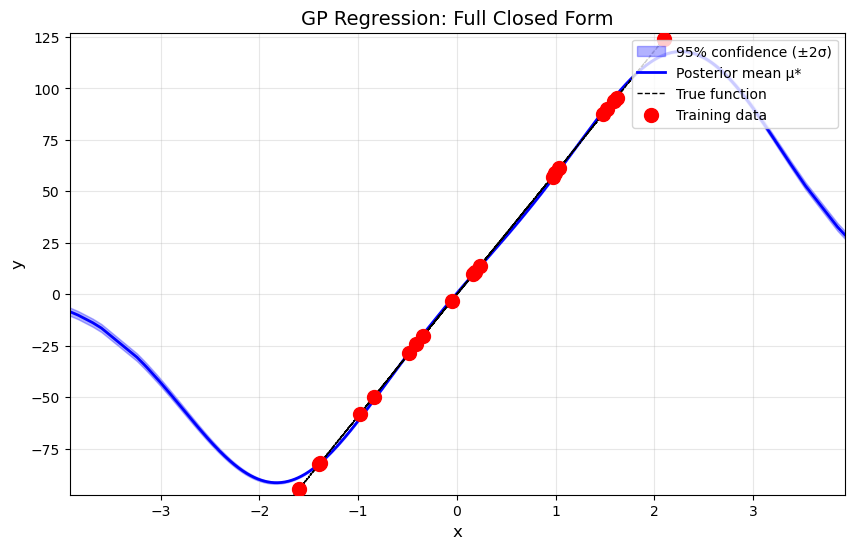

In [58]:
X_full, y_full = make_simple_linear(N_train+N_test, 1, noise=0.1)

X_train = X_full[:N_train]
X_test = X_full[N_train:N_train + N_test]
y_train = y_full[:N_train]
y_true = y_full[N_train:N_train + N_test]

sorted_indices = X_test.squeeze().argsort()
X_test = X_test[sorted_indices]
y_true = y_true[sorted_indices]
# =============================================================================
# FIT AND PREDICT
# =============================================================================

gp = FullGP(lengthscale=1.0, outputscale=1.0, noise=0.2)
gp.fit(X_train, y_train)

mean, var, cov = gp.predict(X_test)
std = torch.sqrt(var.clamp(min=1e-6))

plot_result(X_test, mean, std, X_train, y_train, y_true)

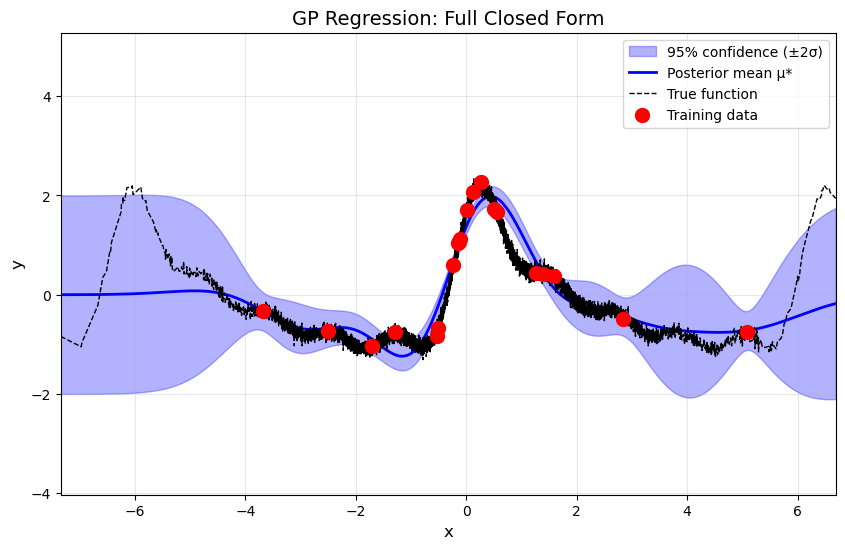

In [59]:
X_full, y_full = make_sinusoidal(N_train+N_test, 1, noise=0.1)

X_train = X_full[:N_train]
X_test = X_full[N_train:N_train + N_test]
y_train = y_full[:N_train]
y_true = y_full[N_train:N_train + N_test]

sorted_indices = X_test.squeeze().argsort()
X_test = X_test[sorted_indices]
y_true = y_true[sorted_indices]
# =============================================================================
# FIT AND PREDICT
# =============================================================================

gp = FullGP(lengthscale=1.0, outputscale=1.0, noise=0.2)
gp.fit(X_train, y_train)

mean, var, cov = gp.predict(X_test)
std = torch.sqrt(var.clamp(min=1e-6))

plot_result(X_test, mean, std, X_train, y_train, y_true)

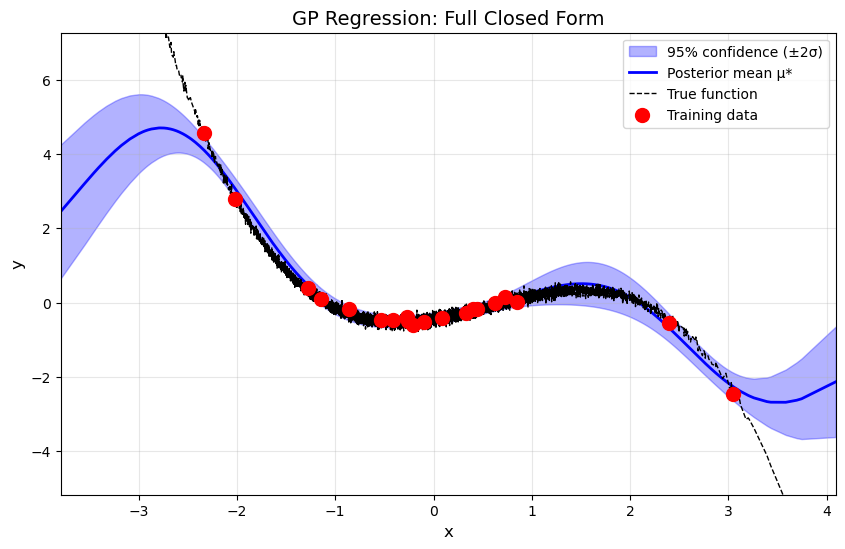

In [60]:
X_full, y_full = make_polynomial(N_train+N_test, 1, degree=3, noise=0.1)

X_train = X_full[:N_train]
X_test = X_full[N_train:N_train + N_test]
y_train = y_full[:N_train]
y_true = y_full[N_train:N_train + N_test]

sorted_indices = X_test.squeeze().argsort()
X_test = X_test[sorted_indices]
y_true = y_true[sorted_indices]
# =============================================================================
# FIT AND PREDICT
# =============================================================================

gp = FullGP(lengthscale=1.0, outputscale=1.0, noise=0.2)
gp.fit(X_train, y_train)

mean, var, cov = gp.predict(X_test)
std = torch.sqrt(var.clamp(min=1e-6))

plot_result(X_test, mean, std, X_train, y_train, y_true)

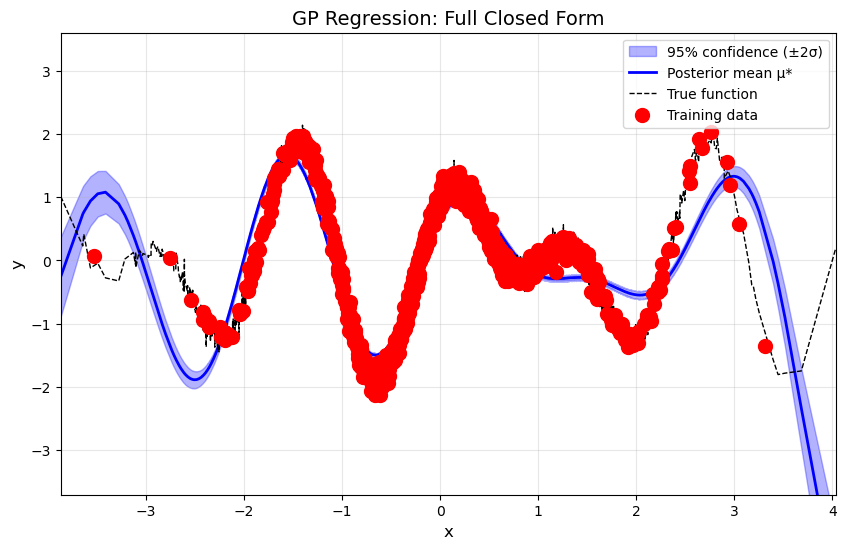

In [62]:
N_train = 1_000
N_test = 10_000
X_full, y_full = make_high_frequency(N_train+N_test, 1, base_freq=3, noise=0.1)

X_train = X_full[:N_train]
X_test = X_full[N_train:N_train + N_test]
y_train = y_full[:N_train]
y_true = y_full[N_train:N_train + N_test]

sorted_indices = X_test.squeeze().argsort()
X_test = X_test[sorted_indices]
y_true = y_true[sorted_indices]
# =============================================================================
# FIT AND PREDICT
# =============================================================================

gp = FullGP(lengthscale=1.0, outputscale=1.0, noise=0.2)
gp.fit(X_train, y_train)

mean, var, cov = gp.predict(X_test)
std = torch.sqrt(var.clamp(min=1e-6))

plot_result(X_test, mean, std, X_train, y_train, y_true)